In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import io
import os
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp

In [3]:
# Define the DDQN network
class Net(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        return self.fc2(x)

# Prepareoffline samples

In [4]:
#experiment: bridge, different pktsize-corresponding the different ddioway?

In [5]:
import pandas as pd

# Path to your CSV file
csv_file = f'..\\DRL_framework\\npdi-stat\\combined_modify.csv'

# Read the CSV file
#df = pd.read_csv(csv_file, header=[0, 1])

In [6]:
import pandas as pd
#state_columns_1 = ["input-rate", "throughput", "latency"]
state_columns = ["input-rate", "throughput", "latency","ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
                   "pcm-pcie_new_skt-0_PCIRdCur", "pcm-pcie_new_skt-0_ItoM"]
#state_columns = ["ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
           #        "pcm-pcie_new_skt-0_PCIRdCur", "pcm-pcie_new_skt-0_ItoM"]
action_column = ["llc-way"]
#state
df = pd.read_csv(csv_file, usecols=state_columns+action_column)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384 entries, 0 to 2383
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ndpi_stats-pcm_new_Socket 0-L3MISS   2384 non-null   float64
 1   ndpi_stats-pcm_new_Socket 0-L3HIT    2384 non-null   float64
 2   ndpi_stats-pcm_new_Socket 0-PhysIPC  2384 non-null   float64
 3   pcm-pcie_new_skt-0_PCIRdCur          2384 non-null   float64
 4   pcm-pcie_new_skt-0_ItoM              2384 non-null   float64
 5   llc-way                              2384 non-null   int64  
 6   input-rate                           2384 non-null   float64
 7   throughput                           2384 non-null   float64
 8   latency                              2384 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 167.8 KB


In [7]:
a_sample = df.iloc[700]
print(a_sample)

ndpi_stats-pcm_new_Socket 0-L3MISS          13.61
ndpi_stats-pcm_new_Socket 0-L3HIT            0.73
ndpi_stats-pcm_new_Socket 0-PhysIPC          4.78
pcm-pcie_new_skt-0_PCIRdCur            8873634.00
pcm-pcie_new_skt-0_ItoM                1053024.00
llc-way                                      4.00
input-rate                                   5.49
throughput                                   5.42
latency                                  11137.80
Name: 700, dtype: float64


In [8]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
state_space = df[state_columns].values 
scaler.fit(state_space)
state_space_scaled = scaler.transform(state_space)

In [9]:
#reward
r_1 = a_sample['throughput']*a_sample['throughput']-a_sample['latency']/100000
print(r_1)

29.265022000000002


In [10]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
   # state = df.loc[i, state_columns].values.tolist()
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
   # next_state = df.loc[i + 1, state_columns].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
  #  reward = df.loc[i, 'throughput'] * df.loc[i, 'throughput']* df.loc[i, 'throughput']-df.loc[i, 'latency']/1000000
    reward = df.loc[i, 'throughput']*df.loc[i, 'throughput']  -df.loc[i, 'latency']/1000000

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [11]:
print(samples_df.iloc[1]['State'])
print(samples_df.iloc[1]['Action'])
print(samples_df.iloc[1]['Next State'])
print(samples_df.iloc[1]['Next Action'])
print(samples_df.iloc[1]['Reward'])
print(samples_df.iloc[1])

[0.94117647 0.9        0.17444173 0.29853862 0.51290685 0.41237113
 0.00103988 0.97824773]
[2.0]
[0.94117647 0.9        0.17444173 0.32776618 0.48110737 0.46391753
 0.0010479  0.98181146]
[2.0]
28.170944899999995
State          [0.941176470588232, 0.8999999999999995, 0.1744...
Action                                                     [2.0]
Next State     [0.941176470588232, 0.8999999999999995, 0.1744...
Next Action                                                [2.0]
Reward                                                 28.170945
Name: 1, dtype: object


In [12]:
class DDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [13]:

#current_q_values = policy_net(state.unsqueeze(0))
#得到所有动作的评分，输出是一个向量，对应每个动作的值[1.2,0.5,3.4,2.1]

#current_q_values = policy_net(state.unsqueeze(0)).gather(1, action.unsqueeze(1))
#得到特定动作的评分，输出是一个值0.5, 如果选了动作2

#next_q_values = target_net(next_state.unsqueeze(0)).max(1)[0].detach()
#找到下一个q值，target_net(next_state.unsqueeze(0))=[1.2,0.5,3.4,2.1]，然后.max(1)[0]输出的是3.4，
#然后.detach()确保3.4再后续梯度中不影响梯度计算， 则next_q_values =3.4

In [14]:
from torch.optim.lr_scheduler import LambdaLR


state_size = 8
action_size = 20

# initialization
policy_net = DDQN(state_size, action_size)
target_net = DDQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() 

optimizer = optim.Adam(policy_net.parameters())
loss_fn = nn.MSELoss()
losses = []

for index, row in samples_df.iterrows():

    # Extract and convert the state, action, next state, and reward from the row
    state = torch.FloatTensor(row['State'])
    next_state = torch.FloatTensor(row['Next State'])
    action = torch.LongTensor([int(row['Action'][0])-1])
    reward = torch.FloatTensor([row['Reward']])
    
    # current q value
    current_q_values = policy_net(state.unsqueeze(0)).gather(1, action.unsqueeze(1))
    next_q_values = target_net(next_state.unsqueeze(0)).max(1)[0].detach()
    expected_q_values = (next_q_values * 0.9) + reward
    loss = loss_fn(current_q_values, expected_q_values.unsqueeze(1))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



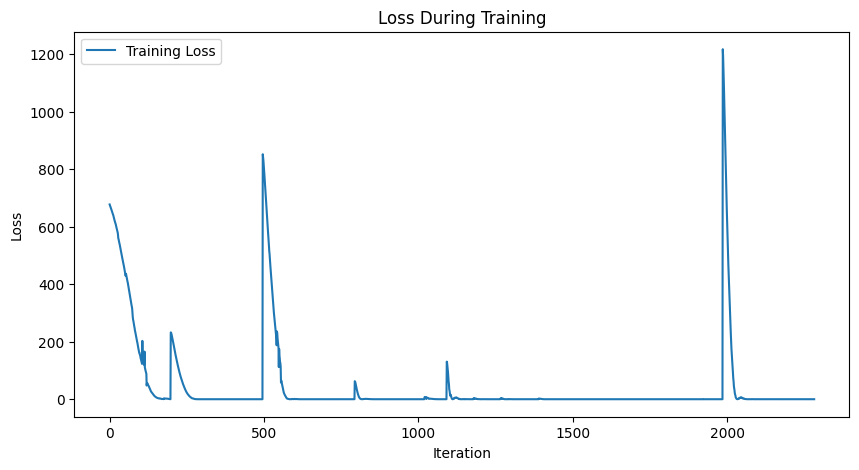

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses[100:], label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


tensor([[ 19.0297,  37.9803,   1.9518,  37.8064,   4.4251,  -6.1420,   4.6793,
          -2.3633,  -4.8786,   0.9152,  -3.5520,   8.0798,   1.5599,   1.3985,
          -4.5006,   6.7639,   2.0312, -11.6495,  -5.7391,  30.4923]])
Action 0: Q Value = 19.029651641845703
Action 1: Q Value = 37.980308532714844
Action 2: Q Value = 1.9517927169799805
Action 3: Q Value = 37.80644989013672
Action 4: Q Value = 4.4251179695129395
Action 5: Q Value = -6.142009258270264
Action 6: Q Value = 4.67931604385376
Action 7: Q Value = -2.363339900970459
Action 8: Q Value = -4.878621578216553
Action 9: Q Value = 0.9151804447174072
Action 10: Q Value = -3.5519933700561523
Action 11: Q Value = 8.079765319824219
Action 12: Q Value = 1.559884786605835
Action 13: Q Value = 1.3984946012496948
Action 14: Q Value = -4.5006303787231445
Action 15: Q Value = 6.763882160186768
Action 16: Q Value = 2.031198263168335
Action 17: Q Value = -11.64951229095459
Action 18: Q Value = -5.739129066467285
Action 19: Q Value = 30.49

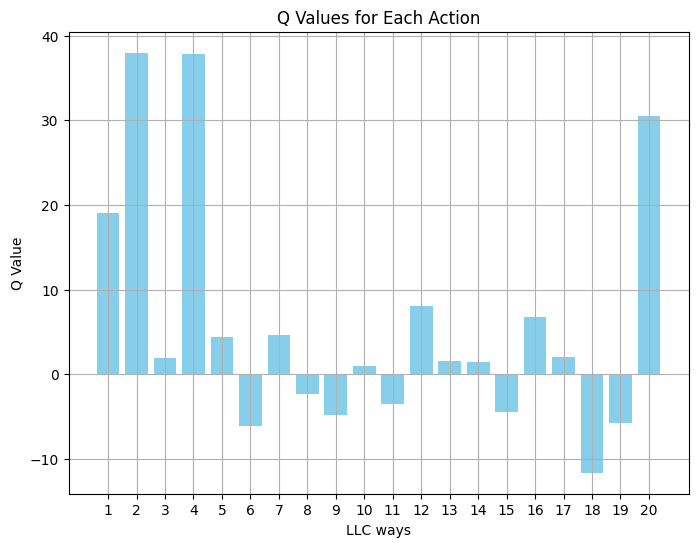

In [17]:
state_tensor = torch.FloatTensor(state).unsqueeze(0)  
policy_net.eval()  
with torch.no_grad():  
    q_values = policy_net(state_tensor)
    print(q_values)

with torch.no_grad():
    q_values = policy_net(state_tensor).squeeze()
    for action, q_value in enumerate(q_values.tolist()):
        print(f"Action {action}: Q Value = {q_value}")
#q_values[1]=27228528
#q_values[3]=28228528

actions = range(20) 
plt.figure(figsize=(5，3))
plt.bar([i+1 for i in actions], q_values, color='skyblue')
plt.title('Q Values for Each Action')
plt.xlabel('LLC ways')
plt.ylabel('Q Value')
plt.xticks([i+1 for i in actions])  
#plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid()
plt.show()


In [155]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
    state = df.loc[i, state_columns].values.tolist()
   # state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = df.loc[i + 1, state_columns].values.tolist()
   # next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'throughput'] * df.loc[i, 'throughput']-df.loc[i, 'latency']

    samples.append((state, action, next_state, next_action, reward))
samples_df_1 = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])
print(samples_df_1.iloc[1]['State'])

[5.65, 5.43, 1313955.1, 3.9, 27.43, 0.43, 8411102.0, 1110634.0]


# Using batch processing

In [60]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
   # state = df.loc[i, state_columns].values.tolist()
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'throughput']*df.loc[i, 'throughput']  -df.loc[i, 'latency']/1000000

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [70]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Extracting row by row index (assuming dataframe is already correctly indexed)
        row = self.dataframe.iloc[index]
        state = torch.FloatTensor(row['State'])
        next_state = torch.FloatTensor(row['Next State'])
        action = torch.LongTensor([int(row['Action'][0])-1])
        # Converting 'Reward' to tensor
        reward = torch.FloatTensor([row['Reward']])
        return state, action, next_state, reward


In [71]:
batch_size = 8
num_epochs = 5
dataset = CustomDataset(samples_df)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_loader

In [72]:
losses.append(loss.item())
for epoch in range(num_epochs): 
    for states, actions, next_states, rewards in data_loader:

        # a batch 
        current_q_values = policy_net(states).gather(1, actions)
        next_q_values = target_net(next_states).detach().max(1)[0]
        expected_q_values = (next_q_values.unsqueeze(1) * 0.9) + rewards

        # ensure current_q_value and expected_q_values is the same
        loss = loss_fn(current_q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        

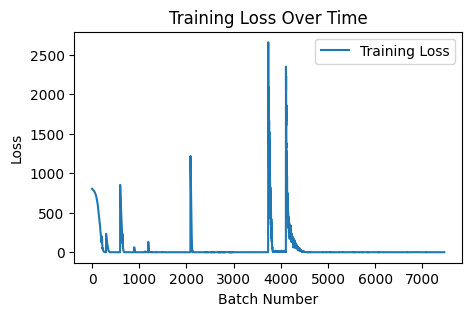

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()


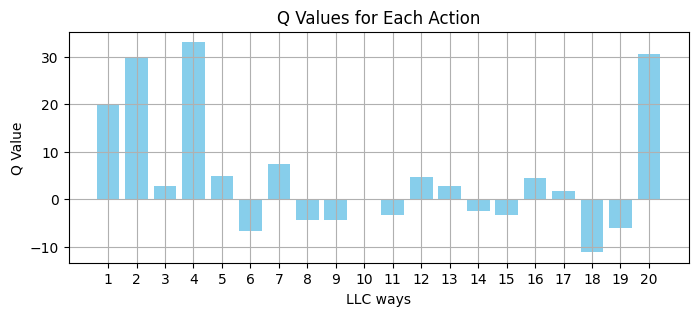

In [77]:
state_tensor = torch.FloatTensor(state).unsqueeze(0)  
policy_net.eval()  
with torch.no_grad():  
    q_values = policy_net(state_tensor)

with torch.no_grad():
    q_values = policy_net(state_tensor).squeeze()
    for action, q_value in enumerate(q_values.tolist()):
        print(f"Action {action}: Q Value = {q_value}")


actions = range(20) 
plt.figure(figsize=(8,3))
plt.bar([i+1 for i in actions], q_values, color='skyblue')
plt.title('Q Values for Each Action')
plt.xlabel('LLC ways')
plt.ylabel('Q Value')
plt.xticks([i+1 for i in actions])  
#plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid()
plt.show()


# offline test

In [81]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
   # state = df.loc[i, state_columns].values.tolist()
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'throughput']*df.loc[i, 'throughput']  -df.loc[i, 'latency']/1000000

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [96]:
total_reward = 0
correct_actions = 0
num_samples = len(samples_df)
predicted_actions_list = [] 
for index, row in samples_df.iterrows():

    # Extract and convert the state, action, next state, and reward from the row
    state = torch.FloatTensor(row['State'])
   # print(state)
    next_state = torch.FloatTensor(row['Next State'])
    action = torch.LongTensor([int(row['Action'][0])-1])
    reward = torch.FloatTensor([row['Reward']])
   # print(reward)
    with torch.no_grad():
        action_values = policy_net(state)
       # print(action_values)
    predicted_action = action_values.argmax().item()
    predicted_actions_list.append(predicted_action) 
    
    if predicted_action == action:
        correct_actions += 1

    # total reward
    total_reward += reward
average_reward = total_reward / num_samples
accuracy = correct_actions / num_samples

if torch.is_tensor(average_reward):
    average_reward = average_reward.item()
if torch.is_tensor(accuracy):
    accuracy = accuracy.item()

print(f"Average Reward: {average_reward:.2f}")


Average Reward: 22.32


# compare with FSM (finite state machine)

In [111]:
from enum import Enum, auto

class State(Enum):
    LOW_KEEP = auto()
    HIGH_KEEP = auto()
    IO_DEMAND = auto()
    CORE_DEMAND = auto()
    RECLAIM = auto()

# Constants for thresholds and LLC ways
DDIO_WAYS_MIN = 1
DDIO_WAYS_MAX = 10  
THRESHOLD_MISS_LOW = 100000  

In [114]:
class IAT_FSM:
    def __init__(self):
        self.state = State.LOW_KEEP
        self.llc_ways_ddio = DDIO_WAYS_MIN  # Starting with minimum allocation
        self.previous_ddio_hit = None
        self.previous_llc_reference = None
    
    def transition(self, ddio_miss, ddio_hit, llc_reference):
        # Example for transitioning from LOW_KEEP state
        if self.state == State.LOW_KEEP:
            if ddio_miss > THRESHOLD_MISS_LOW:
                ddio_hit_decreases = self.previous_ddio_hit is not None and ddio_hit < self.previous_ddio_hit
                llc_reference_increases = self.previous_llc_reference is not None and llc_reference > self.previous_llc_reference
                
                if ddio_hit_decreases and llc_reference_increases:
                    self.state = State.CORE_DEMAND
                else:
                    self.state = State.IO_DEMAND
        
        # Remember to update the previous values at the end of the transition check
        self.previous_ddio_hit = ddio_hit
        self.previous_llc_reference = llc_reference
        
        # Add similar checks for other state transitions
        
    def allocate_llc_ways(self):
        # Based on the current state, allocate LLC ways
        if self.state == State.LOW_KEEP:
            self.llc_ways_ddio = DDIO_WAYS_MIN
        elif self.state == State.HIGH_KEEP:
            self.llc_ways_ddio = DDIO_WAYS_MAX
        # Define allocation logic for other states


In [115]:
# Example usage
iat_fsm = IAT_FSM()

# Simulate receiving data from Poll Prof Data
ddio_miss_count = 120  # Example data
ddio_hit_count = 80    # Example data
llc_reference_count = 150  # Example data

iat_fsm.transition(ddio_miss_count, ddio_hit_count, llc_reference_count)
iat_fsm.allocate_llc_ways()

print(f"Current State: {iat_fsm.state}, LLC Ways for DDIO: {iat_fsm.llc_ways_ddio}")


Current State: State.LOW_KEEP, LLC Ways for DDIO: 1


In [116]:
previous_throughput = throughput_data[0]  # Initialize with the first value

for i in range(len(throughput_data)):
    current_throughput = throughput_data[i]
    current_l3miss = l3miss_data[i]
    
    # Apply FSM logic
    new_llc_ways, action_taken = fsm_logic(current_throughput, previous_throughput, current_l3miss, current_llc_ways)
    
    print(f"Step {i}: Throughput={current_throughput}, L3MISS={current_l3miss}, LLC Ways={new_llc_ways} ({action_taken})")
    
    # Update for next iteration
    current_llc_ways = new_llc_ways
    previous_throughput = current_throughput


Step 0: Throughput=1000, L3MISS=9000, LLC Ways=5 (No Change)
Step 1: Throughput=950, L3MISS=12000, LLC Ways=5 (No Change)
Step 2: Throughput=900, L3MISS=8000, LLC Ways=5 (No Change)
Step 3: Throughput=850, L3MISS=13000, LLC Ways=5 (No Change)
Step 4: Throughput=500, L3MISS=70000, LLC Ways=6 (Increased)
